<a href="https://colab.research.google.com/github/glukonatic/III/blob/master/11Ultra_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ultra

Найдите на Kaggle любую базу с изображениями и напишите генеративную сеть. Удобная база из соревнования cats vs dogs - генерация кошек и собак. Приложите к отчёту лучшие фото и описание архитектуры сети

In [1]:
#@title Подключение библиотек

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D, concatenate, Embedding, multiply 
from keras.layers import Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU 
from keras.layers.convolutional import UpSampling2D, Conv2D
from tensorflow.keras.preprocessing import image
from keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam 

import matplotlib.pyplot as plt 

import numpy as np 
import os

from keras.utils import to_categorical

import imageio
import IPython.display as disp


In [2]:
#@title connect colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title import set

!cp /content/drive/My\ Drive/cats.zip .
!unzip -q cats.zip
!rm cats/cats/*.*
!rm -d cats/cats

In [4]:
#@title Определяем папки с изображениями и размеры, к которым приводим загруженные картинки:
#@markdown высота (дефолтно - 28):
img_rows = 64  #@param {type: "number"}
#@markdown ширина (дефолтно - 28):
img_cols = 64  #@param {type: "number"}
#@markdown ч/б или цвет:
pick_me = "colour"  #@param ['grayscale', 'colour']
# #@markdown размер скрытого слоя:
# latent_dim = 512   #@param {type: "number"}
images_train_dir = 'cats'

if pick_me == "grayscale":
  channels = 1 
else:
  channels = 3

img_shape = (img_rows, img_cols, channels)
#latent_dim = 512 
#batch_size = 128 


In [5]:
#@title Загружаем и обрабатываем изображения

def load_images(images_dir, img_height, img_width, isTrain = False): 
  list_images = []
  categories = []
  for img in os.listdir(images_dir):
    if pick_me == "colour":
      list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width))))
    else:
      list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
    if isTrain:
      category = img.split('.')[0]
      if category == 'cat':
        categories.append(0)
      elif category == 'dog':
        categories.append(1)

  if isTrain: return np.array(list_images), np.array(categories)
  else: return np.array(list_images)

x_train = load_images(images_train_dir, img_rows, img_cols)

x_train = x_train.astype('float32') / 255.


In [6]:
#@title train func

from google.colab import output

def train(generator, discriminator, epochs=30000, batch_size=128): 
  
  valid = np.ones((batch_size, 1)) 
  fake = np.zeros((batch_size, 1)) 

  z = Input(shape=(latent_dim,)) 
  img = generator(z) 
  validity = discriminator(img) 

  combined = Model(z, validity) 
  combined.compile(loss='binary_crossentropy', optimizer=optimizer) 

  sample_interval = epochs//100 
  
  d_loss_list = [] 
  g_loss_list = []
  d_acc_list = []
  
  for epoch in range(epochs): 

    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx] 

    noise = np.random.normal(0, 1, (batch_size, latent_dim)) 
    
    gen_imgs = generator.predict(noise)
      
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 
    g_loss = combined.train_on_batch(noise, valid)
    
    d_loss_list.append(d_loss[0]) 
    g_loss_list.append(g_loss) 
    d_acc_list.append(100*d_loss[1]) 

    if ((epoch % sample_interval == 0) | (epoch == epochs-1)): 
      output.clear()
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
      sample_images(epoch, generator) 
        
  

  plt.plot(d_loss_list, label="Ошибка дискриминатора")
  plt.plot(g_loss_list, label="Ошибка генератора")
  plt.legend()
  plt.show()
  plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
  plt.legend()
  plt.show()

In [7]:
#@title sample images func

def sample_images(epoch, gen): 
  r, c = 2, 5 
  noise = np.random.normal(0, 1, (r * c, latent_dim)) 
  gen_imgs = gen.predict(noise) 
  print(np.min(gen_imgs),np.mean(gen_imgs),np.max(gen_imgs))
  print(gen_imgs[0]-gen_imgs[1])
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0 
  for i in range(r): 
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt, :,:]) 
          axs[i,j].axis('off') 
          cnt += 1
  plt.show() 
  fig.savefig("images/%d.png" % epoch)
  plt.close() 

In [40]:
#@title create generator func

def create_generator(): 

  act = 'tanh'

  generator = Sequential()
  
  generator.add(Dense(latent_dim,input_dim=latent_dim, activation='tanh'))
  #generator.add(Dense(latent_dim*2,activation='tanh'))
  generator.add(Dense(np.prod(img_shape),activation='tanh'))
  generator.add(Reshape((img_shape)))
  
  generator.summary()

  noise = Input(shape=(latent_dim,))
  img = generator([noise]) 

  return Model(noise, img) 

In [41]:
#@title create discriminator func

def create_discriminator():

  neyrons =  512#@param {type: "number"}
  kernelSize = 2 #@param {type: "number"}
  strides = 1 #@param {type: "number"}

  discriminator = Sequential()

  discriminator.add(Conv2D(neyrons, kernel_size=kernelSize, 
                           #strides=strides, 
                           padding="same", input_shape=img_shape))
  discriminator.add(BatchNormalization())
  discriminator.add(Activation("sigmoid"))
  #discriminator.add(LeakyReLU(alpha=0.2))
  
  discriminator.add(Conv2D(neyrons, kernel_size=kernelSize, strides=strides, padding="same"))
  discriminator.add(BatchNormalization())
  discriminator.add(Activation("sigmoid"))
  #discriminator.add(LeakyReLU(alpha=0.2))

  #discriminator.add(Conv2D(neyrons, kernel_size=kernelSize, strides=strides, padding="same"))
  #discriminator.add(BatchNormalization())
  #discriminator.add(Activation("sigmoid"))
  
  #discriminator.add(Conv2D(neyrons, kernel_size=kernelSize, strides=strides, padding="same"))
  #discriminator.add(Activation("sigmoid"))
  
  discriminator.add(Flatten()) 
  discriminator.add(Dense(1, activation='sigmoid')) 
  
  img = Input(shape=img_shape) 
  validity = discriminator(img)
  
  discriminator.summary()

  discriminator = Model(img, validity)

  discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  
  discriminator.trainable = False

  return discriminator 

450 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000000]
-0.9449798 -0.025841279 0.9534742


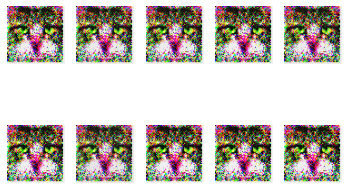

KeyboardInterrupt: ignored

In [42]:
#@title train
#@markdown Эпох учим:
epochs = 5000   #@param {type: "number"}
#@markdown Коэфициент обучения Адама:
adam_koeff = 0.0002 #@param {type: "number"}
#@markdown Размер скрытого слоя:
latent_dim = 128 #@param {type: "number"}
#@markdown Размер батча:
batch_size =  128#@param {type: "number"}

optimizer = Adam(adam_koeff, 0.5)

!mkdir images
!rm /content/images/*.png

generator = create_generator() 
discriminator = create_discriminator()

#input()
train(generator, discriminator, epochs) 
#train(generator, discriminator,1001) 

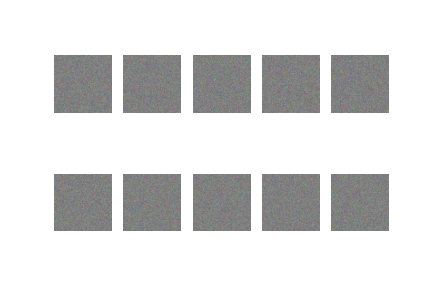

In [43]:
#@title Выведем наглядно гифку

fileslist = os.listdir('images')

idxs = []
for filename in fileslist:
  idxs.append(int(filename.split('.')[0]))

idxs.sort()

path = 'images/'
val = 200
xP = 135
xL = 20
yP = 0

images = []
for e,id in enumerate(idxs):

  img = imageio.imread(path + str(id) + '.png')
  yL = int(432 * (e/len(idxs)))
  for i in range(xL):
    for j in range(yL):
      img[xP+i][yP+j][0] = val
  images.append(img)

imageio.mimsave('All.gif', images)

disp.Image(open('All.gif','rb').read())